![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Trend Analysis of Annual LAI in China

Production date: 09-Jan-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Utilize satellite effecive LAI data to monitor vegetation dynamics under climate change

## ❓ Quality assessment question(s)
**Are satellite data suitable for detecting changes in the yearly mean of effective LAI observed in China over the past 20 years?**

The dataset: Leaf Area Index (LAI) and Fraction Absorbed of Photosynthetically Active Radiation 10-daily gridded data from 1981 to present, by the Climate Data Store (CDS), contains LAI (effective) values derived from observations of different satellites and sensors. LAI is defined as half the developed area of photosynthetically active elements of the vegetation per unit horizontal ground area. It relates to effective LAI through a canopy-dependent structure factor. This parameter is a useful tool for assessing vegetation, understanding ecosystem dynamics, and addressing environmental and agricultural challenges.

The goal of this quality assessment is to analyze the trend of yearly mean LAI (effective) over the past 20 years in China. An increase in LAI has been observed over China in the past two decades due to factors such as climate change and human activities [[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438). Ma et al. (2023) observed a linear trend with a strong positive correlation of true LAI over time. They used data from GLASS LAI, which is based on MODIS [[2]](https://www.sciencedirect.com/science/article/pii/S0034425722000992). Because of the period for analysis, we used version 3 of the dataset, relying on data from SPOT-VGT (Système Probatoire pour l’Observation de la Terre) for the period 2001–2013 and from PROBA-V (Project for On-Board Autonomy) for 2014–2019. Therefore, we analyzed the transition and differences between the data from these two satellites.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Effective LAI values derived from PROBA-V and its predecessor SPOT-VGT show notable differences, likely due to PROBA-V's superior spatial detail. This enhanced resolution, particularly in fragmented landscapes, makes the data from 2014 onwards more reliable.

* Effective LAI values (CDS dataset) are generally lower than true LAI (GLASS dataset) due to differences in canopy structure assumptions. True LAI from GLASS showed a slope of 0.0202 yr⁻¹, closer to PROBA-V's effective LAI than SPOT-VGT's.

* The trend of effective LAI over time shows a possitive linear correlation, which reflects the greening of China over the past two decades. Altough, it is worth mentioning the last full year with information was 2019 at the moment the analysis was carried out.
```

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](satellite_satellite-lai-fapar_validation_q02:section-1)**
 * Download the LAI (effective) variable with dekad frecuency for the period 2001-2019.

**[](satellite_satellite-lai-fapar_validation_q02:section-2)**
 * Plot the effective LAI values over time and calculate linear trends.
 * Analize the results.
   
**[](satellite_satellite-lai-fapar_validation_q02:section-3)**
 * Compare the results obtained in this work and the ones from literature.

## 📈 Analysis and results

(satellite_satellite-lai-fapar_validation_q02:section-1)=
### 1. Request and Download Data

#### Import Packages

In [9]:
from scipy.stats import pearsonr
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set Parameters

Since the year 2020 only has information for the first half of the  year, we only downloaded data from 2001 to 2019.

In [3]:
year_start = 2001
year_stop = 2019

#### Define requests

In [4]:
collection_id = "satellite-lai-fapar"
base_request = {
    "variable": "lai",
    "sensor": "vgt",
    "horizontal_resolution": "1km",
    "product_version": "v3",
    "area": [53, 73, 18, 135],
}

requests = []
for time in pd.date_range(str(year_start), str(year_stop + 1), freq="ME"):
    requests.append(
        base_request
        | {
            "satellite": "spot" if time.year <= 2013 else "proba",
            "year": str(time.year),
            "month": f"{time.month:02d}",
            "nominal_day": ["10", "20", str(time.day)],
        }
    )

#### Define functions to cache

In this step, we also filtered out data flagged as unreliable, keeping only the "good" data. The instructions in the [documentation](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-lai-fapar/D3.3.9-v3.0_PUGS_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.0.1.pdf) related to flags were followed.

In [5]:
def spatial_weighted_mean_over_china(ds):
    regions = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

    spatial_mask = regions[regions.map_keys(["China"])].mask(ds).notnull()
    flag_mask = (ds["retrieval_flag"].astype("int") & 0xFC1) == 0
    lai_mask = ds["LAI"] < 65_535

    ds = ds[["LAI"]].where(spatial_mask & flag_mask & lai_mask)
    return diagnostics.spatial_weighted_mean(ds)

#### Download and transform

In [6]:
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=spatial_weighted_mean_over_china,
)
da = ds["LAI"].groupby("time.year").mean()

100%|██████████| 228/228 [00:07<00:00, 29.10it/s]


(satellite_satellite-lai-fapar_validation_q02:section-2)=
### 2. Plot time series

In [19]:
da.values

array([0.39563351, 0.39747345, 0.40319939, 0.40436953, 0.39948895,
       0.40948193, 0.40769001, 0.43228232, 0.42104475, 0.42800853,
       0.41800598, 0.43288172, 0.47039173, 0.49593169, 0.51579111,
       0.53632915, 0.56801868, 0.57510155, 0.56714279])

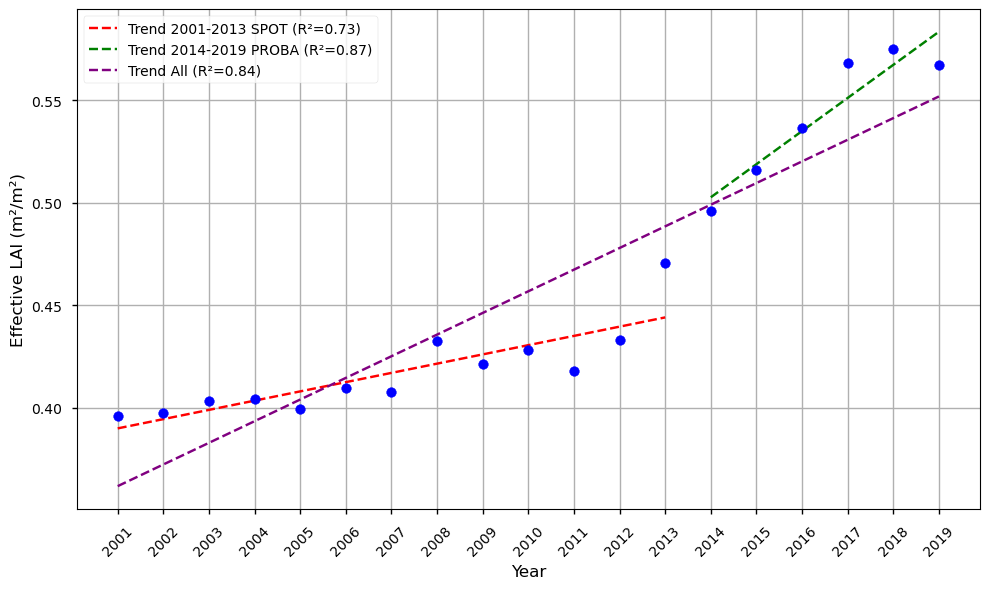

In [17]:
# Extract LAI values into a Python list
lai = da.values.tolist()

# Extract years into a Python list
years = da.coords['year'].values.tolist()

# Splitting data for trendlines
years_2001_2013 = years[:13]
lai_2001_2013 = lai[:13]

years_2014_2019 = years[13:]
lai_2014_2019 = lai[13:]

# Trendline for 2001-2013
slope_2001_2013, intercept_2001_2013, r_value_2001_2013, _, _ = linregress(years_2001_2013, lai_2001_2013)
trendline_2001_2013 = [slope_2001_2013 * x + intercept_2001_2013 for x in years_2001_2013]

# Trendline for 2014-2019
slope_2014_2019, intercept_2014_2019, r_value_2014_2019, _, _ = linregress(years_2014_2019, lai_2014_2019)
trendline_2014_2019 = [slope_2014_2019 * x + intercept_2014_2019 for x in years_2014_2019]

# Trendline for all data
slope_all, intercept_all, r_value_all, _, _ = linregress(years, lai)
trendline_all = [slope_all * x + intercept_all for x in years]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(years, lai, color='blue', zorder=5)
plt.plot(years_2001_2013, trendline_2001_2013, color='red', linestyle='--', label=f'Trend 2001-2013 SPOT (R²={r_value_2001_2013**2:.2f})')
plt.plot(years_2014_2019, trendline_2014_2019, color='green', linestyle='--', label=f'Trend 2014-2019 PROBA (R²={r_value_2014_2019**2:.2f})')
plt.plot(years, trendline_all, color='purple', linestyle='--', label=f'Trend All (R²={r_value_all**2:.2f})')
plt.xticks(ticks=years, labels=years, rotation=45)
# Labels and legend
plt.xlabel('Year', fontsize=12)
plt.ylabel('Effective LAI (m²/m²)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as a file
plt.savefig("/data/wp5/trigoso_camila/LeafIndex/lai_trend_ALL_2001_2019.png", dpi=200, bbox_inches="tight")  # Save as PNG

# Show plot
plt.show()


```{figure} 1ed6b630-351d-48b2-8e53-69514c15ee7a.png
---
name: fig-annual-lai-ALL-CDS
figwidth: 100%
---
Scattered plot of the spatial and yearly mean of effective LAI in China for all years between 2001-2019 with trendlines. 
```

In [12]:
# Display the equations of the trendlines
eq_2001_2013 = f"2001-2013: y = {slope_2001_2013:.4f}x + {intercept_2001_2013:.4f}"
eq_2014_2019 = f"2014-2019: y = {slope_2014_2019:.4f}x + {intercept_2014_2019:.4f}"
eq_all = f"All: y = {slope_all:.4f}x + {intercept_all:.4f}"

print(eq_2001_2013)
print(eq_2014_2019)
print(eq_all)

2001-2013: y = 0.0045x + -8.6438
2014-2019: y = 0.0162x + -32.0480
All: y = 0.0106x + -20.7846


The data presented in ({ref}`fig-annual-lai-ALL-CDS`) was sourced from the [CDS](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=download). We utilized version 3 of this dataset, which incorporates data from different satellites and sensors over varying time periods. For our analysis, we selected data from SPOT-VGT for the period 2001–2013, and from PROBA-V for 2014–2019. SPOT-VGT provided data for 15 years until May 2014, when it was replaced by PROBA-V. Both satellites offer a horizontal resolution of 1 km. Despite sharing the same nominal spatial resolution, their sensors exhibit differing levels of spatial quality. Notably, PROBA-V delivers higher spatial detail, which is particularly significant in fragmented landscapes [[3]](https://publications.jrc.ec.europa.eu/repository/bitstream/JRC96277/lb-na-27327-en-n%20.pdf).

The results of our analysis indicate a positive correlation of effective LAI over time. Notably, the slopes of the linear trends differ significantly depending on the satellite used. For the period 2001–2013, data from SPOT-VGT yielded a slope of 0.0045 yr<sup>-1</sup>. In contrast, for the period 2014–2019, PROBA-V data produced a steeper slope of 0.0162 yr<sup>-1</sup>, which is 3.6 times higher. Given that the analysis encompasses the entire surface of China, PROBA-V likely provides more accurate measurements, particularly in areas with fragmented landscapes. Its ability to capture finer vegetation details and higher LAI values in border regions between agricultural land and other land use types enhances the quality of the measurements.

(satellite_satellite-lai-fapar_validation_q02:section-3)=
### 3. Comparison to Literature

Ma et al. (2023)[[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438) studied the trend of Leaf Area Index (LAI) in China from 2001 to 2020 within the context of climate change. They analyzed its relationship with various parameters, including temperature, precipitation, aerosol optical depth, and photosynthetically active radiation. For their study, they utilized the Global Land Surface Satellite (GLASS) LAI dataset, which was found to be more accurate than the CYCLOPES and Moderate Resolution Imaging Spectroradiometer (MODIS) LAI products when compared to ground measurements [[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438).

The GLASS LAI product is based on MODIS data but addresses several of its limitations, such as frequent temporal fluctuations, large data gaps, high dependence on surface reflectance quality, and low computational efficiency. This was achieved through the application of a deep learning model. Among the four machine learning models tested, the Bidirectional Long Short-Term Memory (Bi-LSTM) model was identified as the most effective solution [[2]](https://www.sciencedirect.com/science/article/pii/S0034425722000992).

An important distinction between the CDS data we used and the GLASS data is that CDS provides effective LAI values, while GLASS offers true LAI values.

The definition of true LAI is half of the total green leaf area per unit of horizontal land surface, often used in 3D simulations [[2]](https://www.sciencedirect.com/science/article/pii/S0034425722000992). In contrast, effective LAI assumes a homogeneous canopy composed of infinitesimally small Lambertian surfaces, resembling a turbid medium. This assumption aligns with the principles of the Two-stream Model, as described in Pinty et al. (2006) [[4]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD005952).

According to Pinty et al.:

"The values of effective LAI appropriate for 1-D models should be smaller than the true values by a factor varying from 0.3 for sparse to 0.8 for dense forest canopies" [[4]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD005952).

As noted by the [documentation](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-lai-fapar/D3.3.9-v3.0_PUGS_CDR_LAI_FAPAR_MULTI_SENSOR_v3.0_PRODUCTS_v1.0.1.pdf) of the CDS dataset, the effective LAI is related to “true” LAI through a canopy-dependent structure factor. Because the extent of the study is China, one potential approach to approximating the true LAI, without resorting to overly complex methods, could involve referencing bibliographic sources to estimate the canopy-dependent structure factor based on land-use or land cover types. For example, using supplementary data, such as MODIS Land Cover data.

```{figure} b838e0c7-e293-44a0-900f-52d7a6aa432e.png
---
name: fig-annual-lai-GLASS-LAI
height: 400px
---
Annual mean true LAI in China from 2001 to 2020 and rendline. Source: (Ma et al. 2023) [[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438) 
```

Therefore, compraring ({ref}`fig-annual-lai-ALL-CDS`) and ({ref}`fig-annual-lai-GLASS-LAI`), it can be observed that, as it would be expected, the values of effective LAI are lower than the ones of the true LAI. The slopes are also lower for the effective LAI. The slope for true LAI was of 0.0202 yr<sup>-1</sup> which is closer to the one obesrved for the effective LAI retrived by PROBA-V than by SPOT-VGT. 

Although calculating true LAI demands additional steps and supplementary data, the effective LAI dataset remains highly valuable. It aligns with the well-documented greening trend observed in China over the past two decades due to human activities and climate change impacts [[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438).

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://www.sciencedirect.com/science/article/pii/S1470160X23012438) Ma, Y., Wang, W., Jin, S., Li, H., Liu, B., Gong, W., Fan, R., & Li, H. (2023). Spatiotemporal variation of LAI in different vegetation types and its response to climate change in China from 2001 to 2020. Ecological Indicators.

[[2]](https://www.sciencedirect.com/science/article/pii/S0034425722000992) Ma, H. & Liang, S. (2022). Development of the GLASS 250-m leaf area index product (version 6) from MODIS data using the bidirectional LSTM deep learning model. Remote Sensing of Environment.

[[3]](https://publications.jrc.ec.europa.eu/repository/bitstream/JRC96277/lb-na-27327-en-n%20.pdf) Meroni, M., Fasbender, D., Balaghi, R., Dali, M., Hafani, M., Haythem, I., Hooker, J., Lahlou, M., Lopez-Lozano, R., Mahyou, H., Moncef, B. M., Sghaier, N., Wafa, T., & Leo, O. (2015). Testing VGT data continuity between SPOT and PROBA-V missions for operational yield forecasting in North African countries. Joint Research Centre (JRC).

[[4]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD005952) Pinty, B., Lavergne, T., Dickinson, R. E., Widlowski, J.-L., Gobron, N., & Verstraete, M. M. (2006). Simplifying the interaction of land surfaces with radiation for relating remote sensing products to climate models. Journal of Geophysical Research: AtmospheresVolume 111, Issue D2.